In [111]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from keras.utils import plot_model
import keras.backend as K

# Set seeds for reproducibility
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [112]:
def truncate(x, feature_cols=range(1), target_cols=range(1), train_len=16, test_len=1):
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len + 1):
        in_.append(x[i:(i + train_len), feature_cols].tolist())
        out_.append(x[(i + train_len):(i + train_len + test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

In [ ]:
fileName = '42001h2021.txt'
dataset = pd.read_csv("42001h2021.txt", sep='\t', lineterminator='\r')

# Data Cleaning
dataset = dataset.replace('\n','', regex=True)
dataset = dataset[1:-1]  # Remove the first and last rows if necessary
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset["WVHT"] = dataset["WVHT"].astype(float)
dataset = dataset[dataset['WVHT'] != 99]  # Remove erroneous entries

# Extract 'WVHT' as NumPy array
data = dataset["WVHT"].to_numpy().reshape((len(dataset["WVHT"]), 1))

In [114]:
train_len = 16
test_len = 1
feature_cols = range(1)
target_cols = range(1)

X_in, X_out = truncate(data, feature_cols=feature_cols, target_cols=target_cols, 
                       train_len=train_len, test_len=test_len)

print(f"Input shape: {X_in.shape}, Output shape: {X_out.shape}")

# Reshape output to (samples, 1)
X_out = X_out.reshape(-1, 1)
print(f"Reshaped Output shape: {X_out.shape}")

Input shape: (2254, 16, 1), Output shape: (2254, 1, 1)
Reshaped Output shape: (2254, 1)


In [115]:
# Split into training and testing sets (70% train, 30% test)
train_size = math.floor(X_in.shape[0] * 0.70)
train_x, train_y = X_in[:train_size], X_out[:train_size]
test_x, test_y = X_in[train_size:], X_out[train_size:]

print(f"Train X shape: {train_x.shape}, Train Y shape: {train_y.shape}")
print(f"Test X shape: {test_x.shape}, Test Y shape: {test_y.shape}")

Train X shape: (1577, 16, 1), Train Y shape: (1577, 1)
Test X shape: (677, 16, 1), Test Y shape: (677, 1)


In [116]:

def quantile_loss(quantile):
    def loss(y_true, y_pred):
        errors = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * errors, (quantile - 1) * errors), axis=-1)
    return loss

In [117]:
def build_model(input_shape):
    input_layer = Input(shape=input_shape)
    initializer = tf.keras.initializers.GlorotNormal()

    lstm1 = LSTM(128, activation='relu', kernel_initializer=initializer, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.4)(lstm1)
    lstm2 = LSTM(64, activation='relu', kernel_initializer=initializer, return_sequences=True)(dropout1)
    dropout2 = Dropout(0.3)(lstm2)
    lstm3 = LSTM(32, activation='relu', kernel_initializer=initializer, return_sequences=False)(dropout2)
    dropout3 = Dropout(0.2)(lstm3)

    # Output Layer
    output = Dense(1)(dropout3)  # Single output for quantile

    model = Model(inputs=input_layer, outputs=output)
    return model

In [118]:
q_low = 0.025  
q_high = 0.975 

model_low = build_model((train_len, 1))
model_high = build_model((train_len, 1))

model_low.compile(loss=quantile_loss(q_low), optimizer=Adam(learning_rate=0.001))
model_high.compile(loss=quantile_loss(q_high), optimizer=Adam(learning_rate=0.001))

print("\nLower Quantile Model Summary:")
model_low.summary()

print("\nUpper Quantile Model Summary:")
model_high.summary()

c:\Users\aades\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



Lower Quantile Model Summary:
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 16, 1)]           0         
                                                                 
 lstm_42 (LSTM)              (None, 16, 128)           66560     
                                                                 
 dropout_42 (Dropout)        (None, 16, 128)           0         
                                                                 
 lstm_43 (LSTM)              (None, 16, 64)            49408     
                                                                 
 dropout_43 (Dropout)        (None, 16, 64)            0         
                                                                 
 lstm_44 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_44 (Dropout)      

In [119]:

epochs = 300
batch_size = 64
patience = 10  

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

# Train the lower quantile model
print("\nTraining Lower Quantile Model (2.5%)")
start_time_low = datetime.datetime.now()
history_low = model_low.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    # callbacks=[early_stopping]
)
end_time_low = datetime.datetime.now()
total_time_low = end_time_low - start_time_low
print(f"Lower Quantile Model Training time: {round(total_time_low.total_seconds(), 2)} seconds")


Training Lower Quantile Model (2.5%)
Epoch 1/300
23/23 [==============================] - 9s 103ms/step - loss: 0.0219 - val_loss: 0.0148
Epoch 2/300
23/23 [==============================] - 2s 66ms/step - loss: 0.0153 - val_loss: 0.0114
Epoch 3/300
23/23 [==============================] - 2s 67ms/step - loss: 0.0148 - val_loss: 0.0108
Epoch 4/300
23/23 [==============================] - 2s 66ms/step - loss: 0.0140 - val_loss: 0.0112
Epoch 5/300
23/23 [==============================] - 2s 67ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 6/300
23/23 [==============================] - 2s 66ms/step - loss: 0.0137 - val_loss: 0.0116
Epoch 7/300
23/23 [==============================] - 2s 66ms/step - loss: 0.0138 - val_loss: 0.0107
Epoch 8/300
23/23 [==============================] - 2s 67ms/step - loss: 0.0129 - val_loss: 0.0095
Epoch 9/300
23/23 [==============================] - 2s 67ms/step - loss: 0.0128 - val_loss: 0.0105
Epoch 10/300
23/23 [==============================] - 2s 66ms

In [120]:
# Train the upper quantile model
print("\nTraining Upper Quantile Model (97.5%)")
start_time_high = datetime.datetime.now()
history_high = model_high.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    # callbacks=[early_stopping]
)
end_time_high = datetime.datetime.now()
total_time_high = end_time_high - start_time_high
print(f"Upper Quantile Model Training time: {round(total_time_high.total_seconds(), 2)} seconds")


Training Upper Quantile Model (97.5%)
Epoch 1/300
23/23 [==============================] - 8s 100ms/step - loss: 0.4682 - val_loss: 0.0209
Epoch 2/300
23/23 [==============================] - 1s 66ms/step - loss: 0.0474 - val_loss: 0.0200
Epoch 3/300
23/23 [==============================] - 1s 65ms/step - loss: 0.0346 - val_loss: 0.0168
Epoch 4/300
23/23 [==============================] - 2s 65ms/step - loss: 0.0323 - val_loss: 0.0188
Epoch 5/300
23/23 [==============================] - 2s 66ms/step - loss: 0.0287 - val_loss: 0.0177
Epoch 6/300
23/23 [==============================] - 1s 65ms/step - loss: 0.0291 - val_loss: 0.0160
Epoch 7/300
23/23 [==============================] - 2s 65ms/step - loss: 0.0270 - val_loss: 0.0153
Epoch 8/300
23/23 [==============================] - 2s 67ms/step - loss: 0.0272 - val_loss: 0.0138
Epoch 9/300
23/23 [==============================] - 2s 65ms/step - loss: 0.0265 - val_loss: 0.0204
Epoch 10/300
23/23 [==============================] - 2s 66m

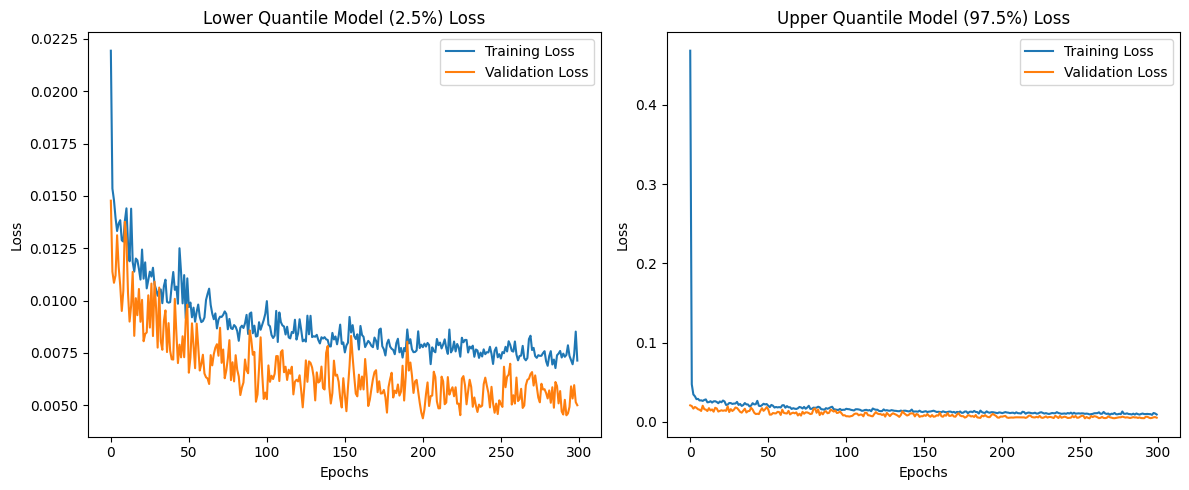

In [121]:
# Plot training history for both models
plt.figure(figsize=(12, 5))

# Lower Quantile Model
plt.subplot(1, 2, 1)
plt.plot(history_low.history['loss'], label='Training Loss')
plt.plot(history_low.history['val_loss'], label='Validation Loss')
plt.title('Lower Quantile Model (2.5%) Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Upper Quantile Model
plt.subplot(1, 2, 2)
plt.plot(history_high.history['loss'], label='Training Loss')
plt.plot(history_high.history['val_loss'], label='Validation Loss')
plt.title('Upper Quantile Model (97.5%) Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [122]:
# Make predictions with both models
print("\nMaking Predictions")
y_l_pred = model_low.predict(test_x, verbose=0).flatten()
y_u_pred = model_high.predict(test_x, verbose=0).flatten()
test_y_flat = test_y.flatten()

print(f"Lower Predictions shape: {y_l_pred.shape}")
print(f"Upper Predictions shape: {y_u_pred.shape}")
print(f"Test Y shape: {test_y_flat.shape}")


Making Predictions
Lower Predictions shape: (677,)
Upper Predictions shape: (677,)
Test Y shape: (677,)


In [123]:
# Calculate PICP and MPIW
K_u = y_u_pred >= test_y_flat
K_l = y_l_pred <= test_y_flat
PICP = np.mean(K_u & K_l)
MPIW = np.mean(y_u_pred - y_l_pred)

# Calculate total training time
total_training_time = total_time_low + total_time_high
print(f"\nTotal Training Time (Lower + Upper Quantile Models): {round(total_training_time.total_seconds(), 2)} seconds")

print(f"\nPICP (Prediction Interval Coverage Probability): {PICP}")
print(f"MPIW (Mean Prediction Interval Width): {round(MPIW, 3)}")


Total Training Time (Lower + Upper Quantile Models): 991.93 seconds

PICP (Prediction Interval Coverage Probability): 0.9763663220088626
MPIW (Mean Prediction Interval Width): 0.3580000102519989


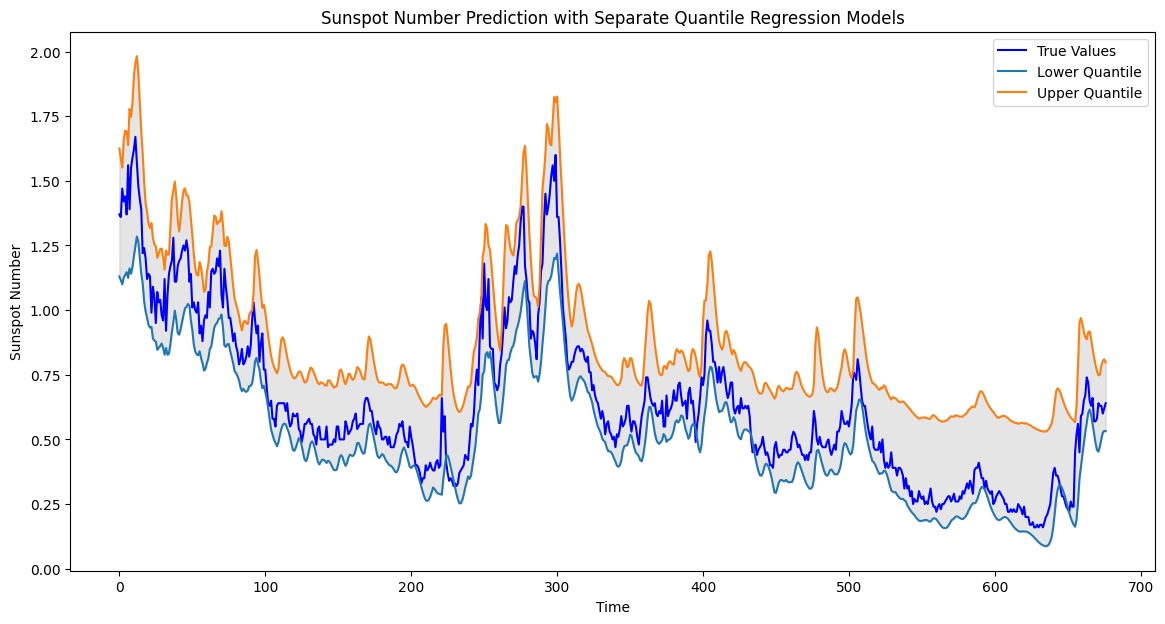

In [124]:
# Optional: Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_y_flat, label='True Values', color='blue')
plt.plot(y_l_pred, label='Lower Quantile')
plt.plot(y_u_pred, label='Upper Quantile')
plt.fill_between(range(len(test_y_flat)), y_l_pred, y_u_pred, color='gray', alpha=0.2)
plt.legend()
plt.title('Sunspot Number Prediction with Separate Quantile Regression Models')
plt.xlabel('Time')
plt.ylabel('Sunspot Number')
plt.show()